# <center> DATA 558 Homework 6 </center>
<center> Cathy Jia </center>
<center> Due May 24, 2019 by 11:59pm </center>

In [1]:
# Display all of the results.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Exercise 1

**In this exercise, you will implement in Python a first version of *your own coordinate descent algorithm* to solve the LASSO problem, that is the l1-regularized least-squares regression problem.**

**Recall from the lectures that the LASSO problem writes as**

$$min\space F(\beta) = \frac{1}{n}\sum _{i=1}^n (y_i - x_i^T \beta)^2+\lambda||\beta||_1$$

## Coordinate Descent
**The coordinate descent algorithm is outlined in Algorithm 1. The algorithm requires a subroutine that performs the partial minimization of the objective for any coordinate $\beta_j$.**

- **Assume that $d=1$ and $n=1$. The sample is then of size 1 and boils down to just $(x, y)$; the learning parameter $\beta$ is then a scalar. The function $F$ writes simply as**

    $$F(\beta)=(y−x\beta)^2 +\lambda|\beta|$$

    **The solution to the minimization problem**
    
    $$min_\beta\space F(\beta)$$

    **is given in Slide 61 of the Week 7 Lecture. Write a function that computes the formula of the solution of this minimization problem.**

    \begin{equation}
        \beta = \Bigg\{
            \begin{matrix}
            (2xy + \lambda) / 2x^2 & if & 2xy < -\lambda \\
            0 & if &2xy \in [-1, +1] \\
            (2xy - \lambda) / 2x^2 & if & 2xy > \lambda
            \end{matrix}
    \end{equation}

- **Assume now that $d > 1$ and $n > 1$. The full minimization problem now writes as**

    $$F(\beta) = \frac{1}{n}\sum _{i=1}^n (y_i - x_i^T \beta)^2+\lambda||\beta||_1$$

    **Coordinate descent proceeds by sequential partial minimization with respect to each coordinate $\beta_j$, that by solving partial minimization problems of form**
    
    $$min_{\beta_j}\frac{1}{n}\sum _{i=1}^n \{yi −(\beta_1 x_{i,1} +···+\beta_j x_{i,j} +···+\beta_d x_{i,d})\}^2 + \lambda (|\beta_1|+···+|\beta_j|+···+|\beta_d|)$$

    **Write a function that computes the formula of the solution of this partial minimization problem with respect to $\beta_j$ for any $j = 1,...,d$.**
    
    \begin{equation}
        \beta_j(c_j) = \Bigg\{
            \begin{matrix}
            (c_j + \lambda) / a_j & if & c_j < -\lambda \\
            0 & if &c_j \in [-1, +1] \\
            (c_j - \lambda) / a_j & if & c_j > \lambda
            \end{matrix}
    \end{equation}
    
    for $a_j = \frac{2}{n}\sum_{i=1}^n x_{i,j}^2, \space c_j = \frac{2}{n}\sum_{i=1}^n x_{i,j}(y_i - \beta_{-j}^T x_{i,-j})$, where $\beta_{-j}$ is $\beta$ without component $j$ and $x_{i,−j}$ is $x_i$ without component $j$.

- **Consider the Hitters dataset. You may download it via**

In [2]:
import pandas as pd
hitters = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv', sep=',', header=0)

**Standardize the data, i.e., center the features and divide them by their standard deviation, and center the outputs. For any categorical variables you should first convert them to indicator variables and then perform the standardization.**

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

hitters = hitters.dropna()

# Create our x matrix with the features and y vector with the response
x = hitters.drop('Salary', axis=1)
x = pd.get_dummies(x, drop_first=True) # convert categorical variables into indicator variables
y = hitters.Salary

# Divide the data into training and test sets.
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

# Standardize the data
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
scaler = preprocessing.StandardScaler().fit(y_train.values.reshape(-1, 1))
y_train = scaler.transform(y_train.values.reshape(-1, 1)).reshape((-1))
y_test = scaler.transform(y_test.values.reshape(-1, 1)).reshape((-1))

# Check the number of data and the number of dimensions
print('Training set: n = %d, d = %d' % (x_train.shape[0], x_train.shape[1]))
print('Test set: n = %d, d = %d' % (x_test.shape[0], x_test.shape[1]))

Training set: n = 197, d = 19
Test set: n = 66, d = 19


- **Write a function `computeobj` that computes and returns $F(\beta)$ for any $\beta$.**

In [4]:
import numpy as np

def computeobj(X, Y, beta, lamb):
    n = X.shape[1]
    return 1/n * np.sum((Y - X.dot(beta))**2) + lamb * (np.sum(np.abs(beta)))

10.368421052631575

- **Write a function `cycliccoorddescent` that implements the cyclic coordinate descent algorithm. The cyclic coordinate descent algorithm proceeds sequentially. At each iteration, the algorithm increments the index $j_t$ of the coordinate to minimize over. Then the algorithm performs partial minimization with respect to the coordinate $\beta_{j_t}$ corresponding to that index. After updating the coordinate $\beta_{j_t}$, the algorithm proceeds to the next iteration. The function takes as input the initial point and the maximum number of iterations. The stopping criterion is the maximum number of iterations.**

In [5]:
def find_new_beta_j(X, Y, beta, lamb, j):
    x_j = X[:, j]
    x_drop_j = np.delete(X, j, 1)
    beta_new = beta
    beta_j = beta[j]
    beta_drop_j = np.delete(beta, j)
    n = X.shape[0]
    a_j = 2/n * x_j.dot(x_j)
    c_j = 2/n * x_j.dot(Y - x_drop_j.dot(beta_drop_j))
    
    if c_j < -lamb:
        beta_new[j] = (c_j + lamb) / a_j
    elif c_j > lamb:
        beta_new[j] = (c_j - lamb) / a_j
    else:
        beta_new[j] = 0
    
    return beta_new

array([0.34970943, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [6]:
import copy

def cycliccoorddescent(X, Y, beta_init, lamb, max_iter):
    # Initialization
    beta = copy.deepcopy(beta_init)
    betas = [copy.deepcopy(beta)]
    t = 0
    d = X.shape[1]
    
    # Stopping criterion: maximum number of iterations
    while t < max_iter:
        # Pick a coordinate index j
        j = np.mod(t, d)
        
        # Find new beta j by minimizing F(beta)
        beta_j = find_new_beta_j(X, Y, beta, lamb, j)
        beta = copy.deepcopy(beta_j)
        # Update beta
        betas.append(copy.deepcopy(beta))
        
        t += 1
    
    return betas

array([0.34970943, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

- **Write a function `pickcoord` that samples uniformly from the set $\{1, . . . , d\}$ .**

In [7]:
def pickcoord(d):
    return np.random.randint(d)

- **Write a function `randcoorddescent` that implements the randomized coordinate descent algorithm. The randomized coordinate descent algorithm proceeds as follows. At each iteration, the algorithm samples the index $j_t$ of the coordinate to minimize over. Then the algorithm performs partial minimization with respect to the coordinate $\beta_{j_t}$ corresponding to that index. After updating the coordinate $\beta_{j_t}$, the algorithm proceeds to the next iteration. The function takes as input the initial point and the maximum number of iterations. The stopping criterion is the maximum number of iterations.**

In [8]:
def randcoorddescent(X, Y, beta_init, lamb, max_iter):
    # Initialization
    beta = copy.deepcopy(beta_init)
    betas = [copy.deepcopy(beta)]
    t = 0
    d = X.shape[1]
    
    # Stopping criterion: maximum number of iterations
    while t < max_iter:
        # Pick a coordinate index j
        j = pickcoord(d)
        
        # Find new beta j by minimizing F(beta)
        beta_j = find_new_beta_j(X, Y, beta, lamb, j)
        beta = copy.deepcopy(beta_j)
        # Update beta
        betas.append(copy.deepcopy(beta))
        
        t += 1
    
    return betas

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.08236904,  0.        ])

- **Set the maximum number of iterations to 1000. In the remainder, the iteration counter `iter` refers here to $t/d$, that is the effective number of passes over all coordinates. Run cross-validation on the training set of the Hitters dataset using `scikit-learn` to find the optimal value of $\lambda$. Run `cycliccoorddescent` and `randcoorddescent` on the training set of the Hitters dataset for that value of $\lambda$ found by cross-validation. Plot the curves of the objective values $F(\beta_t)$ for both algorithms versus the iteration counter `iter` (use different colors). What do you observe?**

    From documentation https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html, the optimization objective of Lasso in `scikit-learn` is

    \begin{equation}
    min_\beta\space \frac{1}{2n} ||Y - X\beta||^2_2 + \alpha ||\beta||_1
    \end{equation}
    
    which can be converted to
    
    \begin{equation}
    min_\beta\space \frac{1}{n} ||Y - X\beta||^2_2 + 2\alpha ||\beta||_1
    \end{equation}
    
    So we have $\lambda = 2\alpha$.

In [9]:
import matplotlib.pyplot as plt

def plot_obj(X, Y, betas1, betas2, lamb):
    d = X.shape[1]
    objs1 = []
    objs2 = []
    for iter in range(0, len(betas1), d):
        beta = betas1[iter]
        obj = computeobj(X, Y, beta, lamb)
        objs1.append(obj)
    for iter in range(0, len(betas2), d):
        beta = betas2[iter]
        obj = computeobj(X, Y, beta, lamb)
        objs2.append(obj)
    plt.figure()
    plt.plot(objs1, label='Cyclic')
    plt.plot(objs2, label='Random')
    plt.title('Objective Value over Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Value')
    plt.legend()
    return

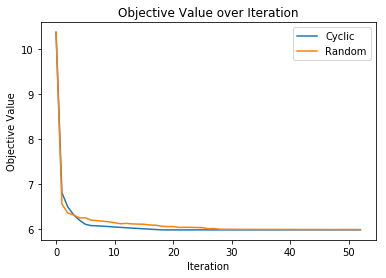

In [10]:
from sklearn.linear_model import LassoCV

# Run cross-validation to find the optimal lamb
reg = LassoCV(cv=5, random_state=0).fit(x_train, y_train)
lamb_opt = 2 * reg.alpha_

# Cyclic coordinate descent
betas_cyclic = cycliccoorddescent(X=x_train, Y=y_train, beta_init=np.zeros(x_train.shape[1]),
                                  lamb=lamb_opt, max_iter=1000)
# Randomized coordinate descent
betas_random = randcoorddescent(X=x_train, Y=y_train, beta_init=np.zeros(x_train.shape[1]),
                                  lamb=lamb_opt, max_iter=1000)

# Plot objective values
plot_obj(x_train, y_train, betas_cyclic, betas_random, lamb_opt)

Observation: The curve produced by cyclic coordinate descent is smoother than the curve produced by random coordinate descent.

- **Denote by $\beta_T$ the final iterates of your coordinate descent algorithms for that value of $\lambda$. Compute $\beta^*$ found by `scikit-learn` for that value of $\lambda$. Plot the curves of the fraction of correct non-zero coefficients (with respect to $\beta^*$) for both algorithms versus the iteration counter `iter` (use different colors). What do you observe? Plot the curves of the fraction of correct zero coefficients for both algorithms (with respect to $\beta^*$) versus the iteration counter `iter` (use different colors). What do you observe?**

In [11]:
def plot_coef(X, betas1, betas2, beta_skl):
    d = X.shape[1]
    nonzero1 = []
    nonzero2 = []
    zero1 = []
    zero2 = []
    for iter in range(0, len(betas1), d):
        beta = betas1[iter]
        nonzero1.append(np.mean(beta_skl[beta!=0] != 0))
        zero1.append(np.mean(beta_skl[beta==0] == 0))
    for iter in range(0, len(betas2), d):
        beta = betas2[iter]
        nonzero2.append(np.mean(beta_skl[beta!=0] != 0))
        zero2.append(np.mean(beta_skl[beta==0] == 0))
    plt.figure()
    plt.plot(nonzero1, label='Cyclic')
    plt.plot(nonzero2, label='Random')
    plt.title('Fraction of Correct Non-Zero Coefficients')
    plt.xlabel('Iteration')
    plt.ylabel('Fraction')
    plt.legend(loc='lower right')
    plt.figure()
    plt.plot(zero1, label='Cyclic')
    plt.plot(zero2, label='Random')
    plt.title('Fraction of Correct Zero Coefficients')
    plt.xlabel('Iteration')
    plt.ylabel('Fraction')
    plt.legend(loc='lower right')
    return

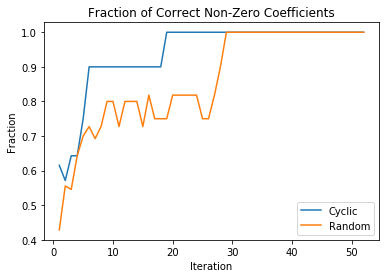

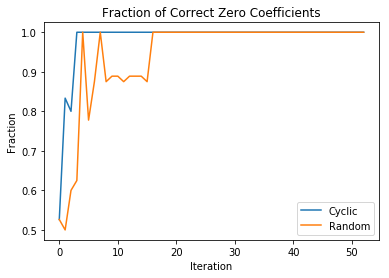

In [12]:
# Plots
beta_star = reg.coef_
plot_coef(x_train, betas_cyclic, betas_random, beta_star)

Observation: There is a increase in fraction of correct non-zero/zero coefficients by iterations. The increase from random coordinate descent is slower.

# Exercise 2

**In this problem you will generate simulated data and then perform PCA on the data. You will use *your own normalized Oja algorithm* for PCA. Note that “first two principal component score vectors” refers to the results from projecting the original data to a two-dimensional space with PCA.**

### (a)

**Generate a simulated data set with 30 observations in each of three classes (i.e. 90 observations total), and 60 features. Hint: There are a number of functions in `numpy` that you can use to generate data. One example is the `numpy.random.normal()` function; `numpy.random.uniform()` is another option. Be sure to add a mean shift to the observations in each class so that there are three distinct classes.**

In [13]:
import numpy as np

np.random.seed(0)
observations = np.random.normal(loc=0, scale=1, size=(90,60))
observations[30:60,:] += 2
observations[60:90,:] -= 2

labels = np.ones([90,])
labels[30:60,] = 2
labels[60:90,] = 3

### (b)

**Run *your own normalized Oja algorithm* on the 90 observations. This algorithm was discussed in the week 8 lecture. Plot the first two principal component score vectors. Compare your results to the ones obtained with scikit-learn’s PCA algorithm. Use a different color to indicate the observations in each of the three classes. If the three classes appear separated in this plot, then you’re done. If not, then return to part (a) and modify the simulation so that there is greater separation between the three classes.**

In [14]:
def oja(A, max_iter=1000):
    n, d = A.shape
    w = np.random.normal(size=(d,))
    w /= np.linalg.norm(w)
    t = 0
    lamb = w.T.dot(A.dot(w))
    # iterate for k = 0, ..., max_iter-1
    while t < max_iter:
        eta = 0.1
        w = w + eta * A.dot(w) # update w
        w /= np.linalg.norm(w) # update top eigenvector
        lamb = w.T.dot(A.dot(w)) # update top eigenvalue
        t += 1
    return lamb, w

def mu(A):
    return np.mean(A, axis=0)

def covariance(A):
    n, d = A.shape
    mu_x = mu(A)
    z = A - mu_x[np.newaxis, :]
    cov = z.T.dot(z) / n
    return cov

In [15]:
# Find the number of observations and the number of dimensions
n, d = observations.shape

# The first principal component
cov = covariance(observations)
lamb1, v1 = oja(cov)

# The k-th principal component vector maximize the variance of projection of x
project = observations - observations.dot(v1.reshape(d,1)).dot(v1.reshape(d,1).T)
cov = covariance(project)
lamb2, v2 = oja(cov)

print("Eigenvalue = %f\nThe first principal component:\n" % lamb1, v1)
print("\nEigenvalue = %f\nThe second principal component:\n" % lamb2, v2)

Eigenvalue = 158.261651
The first principal component:
 [0.1297775  0.1191286  0.12845199 0.13612468 0.13721485 0.12203568
 0.11837849 0.13824703 0.11801335 0.13929057 0.12651902 0.1269919
 0.11887687 0.12844037 0.12214777 0.14078031 0.1222468  0.1399122
 0.13038394 0.11598612 0.12020604 0.12869044 0.14948367 0.12707938
 0.12508135 0.11570237 0.12163758 0.14138264 0.11915887 0.14456968
 0.12906176 0.12484713 0.12787161 0.13177457 0.12913919 0.13079662
 0.13351546 0.12936292 0.11734001 0.1361329  0.1222923  0.12862486
 0.10589909 0.13299072 0.13165329 0.13251305 0.12476089 0.12379886
 0.13125639 0.13235677 0.14323789 0.1337259  0.13161948 0.1324931
 0.1359337  0.11997453 0.13811305 0.12975282 0.12912649 0.1288156 ]

Eigenvalue = 2.860525
The second principal component:
 [-0.15794765 -0.04313139  0.00830847  0.01871303  0.03521937  0.15733308
 -0.18909483  0.17316047  0.28985044  0.08006187  0.06391626  0.00967291
  0.13361478  0.02539325  0.06829625  0.07952021  0.01212919 -0.08650575
 

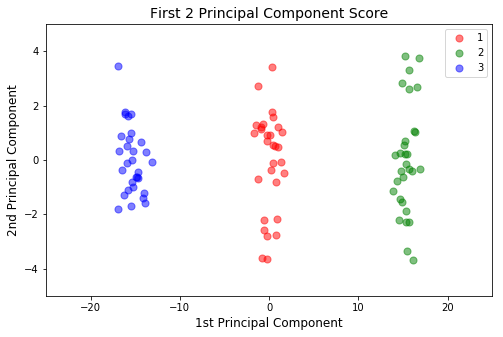

In [16]:
# Plot the first two principal component score vectors
import matplotlib.pyplot as plt

center = observations - mu(observations)
score = center.dot(np.array([v1,v2]).T)

fig, ax = plt.subplots(figsize=(8,5))
colors = {1:'red', 2:'green', 3:'blue'}
for c in colors:
    idx = np.where(labels == c)
    plot = ax.scatter(score[idx,0], score[idx,1], c=colors[c], label=c, s=50, alpha=.5)
plot = ax.legend()
plot = plt.xlim(-25, 25)
plot = plt.ylim(-5, 5)
plot = plt.xlabel("1st Principal Component", fontsize=12)
plot = plt.ylabel("2nd Principal Component", fontsize=12)
plot = plt.title("First 2 Principal Component Score", fontsize=14)
plt.show()

In [17]:
# Use PCA algorithm from sklearn
from sklearn.decomposition import PCA

pca = PCA(n_components=60)
pca = pca.fit(observations)
print("Eigenvalue = %f\nThe first principal component:\n" % pca.explained_variance_[0],pca.components_[0])
print("\nEigenvalue = %f\nThe second principal component:\n" % pca.explained_variance_[1],pca.components_[1])

Eigenvalue = 160.039872
The first principal component:
 [0.1297775  0.1191286  0.12845199 0.13612468 0.13721485 0.12203568
 0.11837849 0.13824703 0.11801335 0.13929057 0.12651902 0.1269919
 0.11887687 0.12844037 0.12214777 0.14078031 0.1222468  0.1399122
 0.13038394 0.11598612 0.12020604 0.12869044 0.14948367 0.12707938
 0.12508135 0.11570237 0.12163758 0.14138264 0.11915887 0.14456968
 0.12906176 0.12484713 0.12787161 0.13177457 0.12913919 0.13079662
 0.13351546 0.12936292 0.11734001 0.1361329  0.1222923  0.12862486
 0.10589909 0.13299072 0.13165329 0.13251305 0.12476089 0.12379886
 0.13125639 0.13235677 0.14323789 0.1337259  0.13161948 0.1324931
 0.1359337  0.11997453 0.13811305 0.12975282 0.12912649 0.1288156 ]

Eigenvalue = 2.892666
The second principal component:
 [-0.15794762 -0.04313137  0.00830844  0.0187132   0.03521939  0.15733314
 -0.18909466  0.17316044  0.28985049  0.08006189  0.06391638  0.00967284
  0.13361515  0.0253934   0.0682962   0.07952053  0.01212931 -0.08650576
 

# Exercise 3
**In this exercise, we will generate simulated data, and will then use this data to fit a lasso model. You should use Scikit-learn in this exercise for fitting the lasso model and performing cross-validation.**

### (a)
**Use the `numpy.random.normal()` function to generate a predictor X of length n = 100, as well as a noise vector $\epsilon$ of length n = 100.**

In [160]:
X = np.random.normal(loc=5, scale=1, size=100)
eps = np.random.normal(loc=0, scale=0.1, size=100)
print('Predictor X =\n', X)
print('\nNoise epsilon =\n', eps)

Predictor X =
 [4.52009609 4.5838549  4.95791963 4.02392153 5.06320763 5.94602929
 3.35603735 5.59895673 3.19866716 3.45154939 5.45217514 4.64057387
 5.37044757 5.41741896 5.49003882 6.62582619 4.25870692 5.14764638
 7.17543713 5.26513647 5.84332537 3.75074656 5.09349747 6.50499995
 6.52776624 5.408234   4.09344499 4.40959041 6.34175642 5.3184496
 3.46029689 5.70039627 5.56816313 5.63993769 6.01821134 4.41053065
 5.21351311 4.32944831 4.70024325 5.58329486 3.78650375 4.42393736
 5.71474812 5.50893629 6.38736339 4.43551168 5.2992626  5.14677126
 6.04273157 4.97714151 5.09060346 4.02420385 5.09115524 5.13448158
 4.9608652  5.02422483 4.98051874 6.09536671 5.21294054 6.8702194
 5.41600566 3.11001653 5.3620967  4.95808363 5.70543846 5.17986131
 4.42315544 5.33512388 3.70308903 6.84511655 5.43765826 5.79378718
 6.58199215 5.32743219 5.63397907 4.26846379 8.03192968 4.07826883
 4.93960517 3.52759145 4.99737172 3.91339292 5.04208743 6.14918491
 6.62777748 4.92834334 5.85366568 7.22733521 2.91

### (b)
**(b) Generate a response vector Y of length n = 100 according to the model**

$$Y = \beta_0 + \beta_1X + \beta_2X^2  + \beta_3X^3 + \epsilon,$$
**where $\beta_0$, $\beta_1$, $\beta_2$, and $\beta_3$ are constants of your choice. Here superscripts denote powers of $X$.**

In [161]:
beta0 = 0.8
beta1 = 0.5
beta2 = 0.01
beta3 = 0.02
Y = beta0 + beta1 * X + beta2 * X**2 + beta3 * X ** 3 + eps
print('Response Y =\n', Y)

Response Y =
 [ 5.21469943  5.26224575  5.98796894  4.12552803  6.20754741  8.33134438
  3.31535158  7.36785433  3.28186085  3.4619101   7.09818607  5.30476436
  6.85743842  6.67292841  7.3000197  10.42959415  4.69872549  6.41364226
 12.14723132  6.6767092   8.11646052  4.08323009  6.13478739  9.98700885
 10.06160973  7.05379254  4.39280923  4.94490259  9.48757595  6.71942503
  3.46061725  7.67981194  7.31694833  7.33910654  8.65557469  5.05455325
  6.55466113  4.75335109  5.43805036  7.58039452  4.01515885  4.89471136
  7.63703647  7.30638346  9.56553181  5.06692961  6.68964591  6.43809118
  8.76191213  5.96596157  6.32554806  4.26202144  6.23092942  6.33899575
  6.1644107   6.14763664  5.98715867  8.59870524  6.50676316 11.19146539
  7.02528058  2.99402764  6.82133674  6.01975316  7.61705881  6.38437
  5.02334993  6.64803567  4.03710899 11.05292334  7.16774622  7.95092296
  9.89208531  6.84326785  7.63612706  4.46444689 15.7994303   4.37282516
  5.88399411  3.69376009  5.98618573  4.

### (c)
**Now fit a lasso model to the simulated data, using $X$, $X^2$, . . . , $X^{10}$ as predictors. Use cross-validation to select the optimal value of $\lambda$. Create plots of the cross-validation error as a function of $\lambda$. Report the resulting coefficient estimates, and discuss the results obtained.**

Lasso Model
beta0 = 2.7380361903
beta1 = 0.0000000000
beta2 = 0.0000000000
beta3 = 0.0000000000
beta4 = 0.0076992843
beta5 = -0.0002070214
beta6 = -0.0000467183
beta7 = -0.0000027200
beta8 = -0.0000000608
beta9 = 0.0000000179
beta10 = 0.0000000044

Optimal value of lambda: 230838.8314907775
Accuray score: 0.9027246303


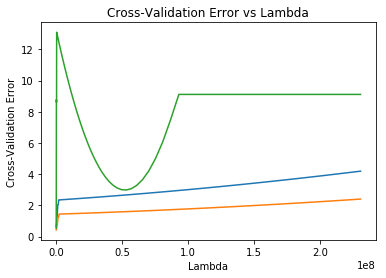

In [162]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

x = np.array([X**i for i in range(1,11)]).T

# Fit a lasso model
model = Lasso().fit(x, Y)
intercept = model.intercept_
betas = model.coef_
print('Lasso Model\nbeta0 = %.10f' % intercept)
for i in range(len(betas)):
    print('beta%d = %.10f'% (i+1, betas[i]))

# Run cross-validation to find the optimal lamb
model = LassoCV().fit(x, Y)
lamb_opt = model.alpha_
print('\nOptimal value of lambda: %.10f' % lamb_opt)
score = model.score(x, Y)
print('Accuray score: %.10f' % score)
lambs = model.alphas_
mse = model.mse_path_


# Cross-validation error plot
plot = plt.figure()
plot = plt.plot(lambs, mse)
plot = plt.title('Cross-Validation Error vs Lambda')
plot = plt.xlabel('Lambda')
plot = plt.ylabel('Cross-Validation Error')

### (d)
**Now generate a response vector $Y$ according to the model**
$$Y = \beta_0 + \beta_7X^7 + \epsilon,$$
**and fit a lasso model. Discuss the results obtained.**

In [163]:
Y = intercept + betas[6] * X ** 7 + eps
print('Response Y =\n', Y)

# Fit a lasso model
model = Lasso().fit(x, Y)
intercept = model.intercept_
betas = model.coef_
print('\nLasso Model\nbeta0 = %.10f' % intercept)
for i in range(len(betas)):
    print('beta%d = %.10f'% (i+1, betas[i]))
score = model.score(x, Y)
print('\nAccuray score: %.10f' % score)

Response Y =
 [ 2.73648889  2.65628074  2.56353023  2.54011705  2.52956737  2.02357552
  2.69371656  2.21340603  2.8543885   2.71678658  2.38187048  2.58241581
  2.3735071   2.05641871  2.47329009  1.27306394  2.71216762  2.52428109
 -0.07002178  2.48069273  2.1683481   2.9214891   2.38182297  1.40358466
  1.37264098  2.46341453  2.69235677  2.68067538  1.62938558  2.37923927
  2.70396312  2.20607215  2.25670443  2.05734298  2.08509544  2.78854412
  2.49522587  2.63863367  2.59040584  2.47401456  2.80042268  2.60322268
  2.11698358  2.42387956  1.51016398  2.75333627  2.40171572  2.55095864
  2.10025716  2.49604314  2.57978828  2.67614946  2.48379664  2.48307595
  2.73302569  2.5648022   2.50921281  1.7379335   2.44882639  0.77188074
  2.4127984   2.67106484  2.36070289  2.59492792  2.12708075  2.41240568
  2.73335097  2.2620957   2.94489933  0.76987701  2.49329573  2.17057918
  0.94719598  2.47847358  2.37301469  2.46042094 -3.15236101  2.69774665
  2.50255908  2.84713207  2.46801618 

# Data Competition Project

**Read the announcement "Data Competition 2" on Canvas. Convert each image into a feature vector using the provided extract features.py script. We strongly recommend you perform this task on AWS.**

- **Pick two classes of your choice from the dataset. Train an $l_2$-regularized logistic regression classifier on the training set using your own fast gradient algorithm with $\lambda$ = 1. Plot, with different colors, the *misclassification error* on the training set and on the validation set vs iterations.**

In [19]:
import sklearn.preprocessing

# Load data
x_train = np.load('train_features.npy')
y_train = np.load('train_labels.npy')
x_val = np.load('val_features.npy')
y_val = np.load('val_labels.npy')

# Subset training data: classes 0 and 1
class1 = 0
class2 = 1
xtrain = x_train
ytrain = y_train
idx_train = np.array([np.where(ytrain==class1),np.where(ytrain==class2)]).reshape(-1)
xtrain = xtrain[idx_train]
ytrain = ytrain[idx_train]

# Standardize the data
scaler = sklearn.preprocessing.StandardScaler()
scaler = scaler.fit(np.array(xtrain))
xtrain = scaler.transform(xtrain).T
scaler = scaler.fit(np.array(x_train))
x_train = scaler.transform(x_train).T
scaler = scaler.fit(np.array(x_val))
x_val = scaler.transform(x_val).T
ytrain = ytrain.T
y_train = y_train.T
y_val = y_val.T

# Change label to +/- 1
ytrain[ytrain!=class2] = -1

print('Training subset')
print('Number of observations: %d' % xtrain.shape[1])
print('Number of dimension: %d' % xtrain.shape[0])
print('\nTraining set')
print('Number of observations: %d' % x_train.shape[1])
print('Number of dimension: %d' % x_train.shape[0])
print('\nValidation set')
print('Number of observations: %d' % x_val.shape[1])
print('Number of dimension: %d' % x_val.shape[0])

Training subset
Number of observations: 1000
Number of dimension: 4096

Training set
Number of observations: 50000
Number of dimension: 4096

Validation set
Number of observations: 10000
Number of dimension: 4096


In [20]:
# Define functions
def computegrad(X, Y, beta, lamb):
    n = X.shape[1]
    p = np.exp(np.multiply(-Y.T,X.T.dot(beta)))/(1+np.exp(np.multiply(-Y.T,X.T.dot(beta))))
    p = np.diag(p)
    return -1/n*X.dot(p).dot(Y)+2*lamb*beta

def obj(X, Y, beta, lamb):
    n = X.shape[1]
    return 1/n*np.sum(np.log(1+np.exp(np.multiply(-Y.T,X.T.dot(beta))))) + lamb*np.linalg.norm(beta)**2

def backtracking(X, Y, beta, grad, init_eta, lamb, max_itr=10):
    norm_grad = np.linalg.norm(grad)
    eta = init_eta
    itr = 0
    while itr < max_itr:     
        if obj(X, Y, beta-eta*grad, lamb) <= (obj(X, Y, beta, lamb)-0.5*eta*norm_grad**2):
            break
        else:
            eta = 0.8 * eta
        itr += 1
    return eta

def initEta(X, lamb):
    n = X.shape[1]
    return 1/(max(np.linalg.eigvals(1/n*X.dot(X.T)))+lamb)

def fastgradalgo(X, Y, init, lamb, eps, max_iter=1000):
    beta = init
    theta = init
    # initial step-size value
    eta = initEta(X, lamb)
    grad = computegrad(X, Y, theta, lamb)
    vals = [beta]
    t = 0
    # The stopping criterion is norm(grad) <= eps
    while (np.linalg.norm(grad) > eps and t < max_iter):
        eta = backtracking(X, Y, beta, grad, eta, lamb)
        temp = beta
        beta = theta - eta * grad
        theta = beta + t/(t+3)*(beta-temp)
        vals.append(beta)
        grad = computegrad(X, Y, theta, lamb)
        t += 1
    return np.array(vals)

def predict(X, beta, cls1, cls2, threshold=0.5):
    pred = 1/(1+np.exp(-X.T.dot(beta))) > threshold # logistic function
    pred = pred.astype(int) # True 1 False 0
    pred[pred==0] = cls1
    pred[pred==1] = cls2
    return pred.T

def compME(X, Y, beta):
    pred = predict(X, beta, class1, class2)
    err = np.mean(pred != Y)
    return err

def ME_plot(X1, Y1, X2, Y2, vals):
    me1 = []
    me2 = []
    for val in vals:
        me1.append(compME(X=X1, Y=Y1, beta=val))
        me2.append(compME(X=X2, Y=Y2, beta=val))
    
    plt.figure()
    plt.plot(me1, label='Training Set')
    plt.plot(me2, label='Validation Set')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Misclassification Error')
    plt.title('Misclassification Error', fontsize=13)
    plt.legend()
    plt.show()
    return

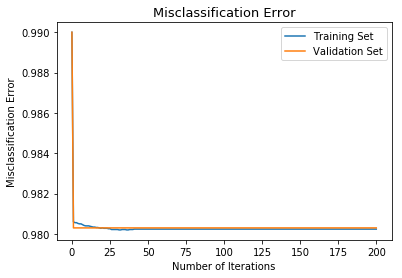

In [21]:
# Run fast gradient algorithm
vals_fg = fastgradalgo(X=xtrain, Y=ytrain, init=np.zeros([xtrain.shape[0],]), lamb=1, eps=0.0001)

# Plot misclassification error
ME_plot(X1=x_train, Y1=y_train, X2=x_val, Y2=y_val, vals=vals_fg)

- **Find the value of the regularization parameter $\lambda$ using cross-validation; you may use scikit-learn’s built-in functions for this purpose. Train an $l_2$-regularized logistic regression classifier on the training set using your own fast gradient algorithm with that value of $\lambda$ found by cross-validation. Plot, with different colors, the *misclassification error* on the training set and on the validation set vs iterations.**

The optimal lambda is 0.0021406662


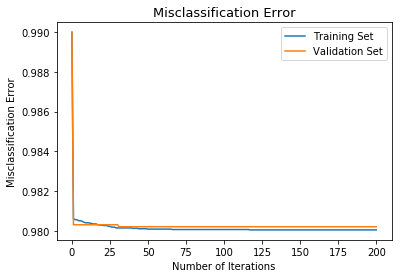

In [24]:
from sklearn.linear_model import LogisticRegressionCV

# Find optimal regularization parameter lamb_opt
clf = LogisticRegressionCV(Cs=20).fit(xtrain.T, ytrain)
n = xtrain.shape[1]
lamb_opt = 1/ (2 * n * clf.C_)
print('The optimal lambda is %.10f' % lamb_opt)

# Run fast gradient algorithm
vals_fg = fastgradalgo(X=xtrain, Y=ytrain, init=np.zeros([xtrain.shape[0],]), lamb=lamb_opt, eps=0.0001)

# Plot misclassification error
ME_plot(X1=x_train, Y1=y_train, X2=x_val, Y2=y_val, vals=vals_fg)

In [25]:
# temp score for validation
pred = predict(x_val, vals_fg[-1], 0, 1)
np.mean(pred==y_val)

0.0198

In [ ]:
# Load and standardize test set 
x_test = np.load('test_features.npy')
scaler = sklearn.preprocessing.StandardScaler()
scaler = scaler.fit(x_test)
x_test = scaler.transform(x_test).T

# Predict
pred = predict(x_test, vals_fg[-1], 0, 1)
pred = pred.reshape(-1)

# Write to submission.csv
df = pd.read_csv('sample_submission.csv')
df['Category'] = pred
df.to_csv('submission.csv',index=False)